Наиболее простые модели нейронных сетей: **однослойный и многослойный персептрон**.



**Однослойный персептрон (персептрон Розенблатта)** - однослойная нейронная сеть, все нейроны которой имеют пороговую функцию активации.

$f(x) = \begin{cases}
1, \text{ если }\text{$x \geq T$} \\
0 \text{ в остальных случаях}
\end{cases}
$

Признаки $x_1,x_2,x_3,\cdots,x_n$ от входного слоя сразу подаются на выходной слой, который преобразует их и выдает ответ. На каждом ребре от нейрона входного слоя к нейрону выходного слоя написан вес признака.



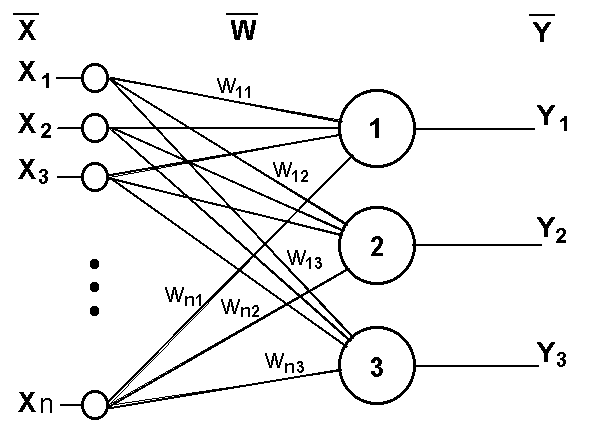

**Многослойный персептрон (MLP)** - нейронная сеть, в которой входной сигнал преобразуется в выходной, проходя последовательно через промежуточные, скрытые слои.
В этой модели персептрона должен быть хотя бы один скрытый слой.

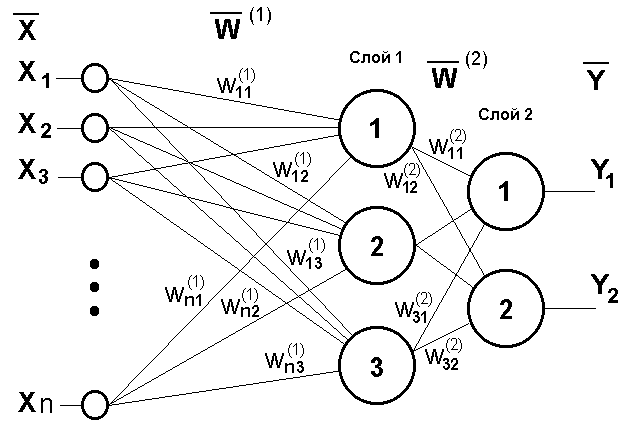

Мы будем использовать многослойный персептрон для классификации по тональности.

In [ ]:
import pandas as pd
from string import punctuation # набор знаков препинания
from collections import Counter # словарь для подсчета объектов

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn # слои
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler # работа с данными
import torch.nn.functional as F # паддинг
from torch.nn.utils.rnn import pad_sequence # паддинг
import torch.optim as optim # оптимизация

### Загрузка данных

В качестве данных будем использовать русскоязычный корпус коротких текстов [RuTweetCorp](https://www.elibrary.ru/item.asp?id=20399632).

Корпус разбит на два класса: твиты с положительной окраской (`positive.csv`) и твиты с отрицательной окраской (`negative.csv`).

---

Twitter — организация, деятельность которой запрещена на территории Российской Федерации.

In [ ]:
!wget https://raw.githubusercontent.com/Xeanst/NN_in_compling/main/03_torch_mlp/positive.csv
!wget https://raw.githubusercontent.com/Xeanst/NN_in_compling/main/03_torch_mlp/negative.csv

В корпусе указано много разных параметров, но нас будут интересовать только сами тексты (`text`) и тональность (`tone`). Объединим тексты с позитивной и негативной окраской (`all_data`), при этом взяв только нужные столбцы.

In [ ]:
positive = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
positive.head()

In [ ]:
negative = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
negative['tone'] = 0

In [ ]:
all_data = pd.concat([positive[['text','tone']], negative[['text','tone']]], ignore_index=True)
print(len(all_data))
all_data.head()

Когда мы работали с алгоритмами машинного обучения, то использовали гораздо меньшее количество данных.

В нейросетях нам нужен большой объем данных, чтобы успешно обучить большое количество параметров. Мы будем работать с видеокартами, которые позволяют ускорить вычисления.

Разделим данные на обучающую и валидационную выборку.

In [ ]:
train_sentences, val_sentences = train_test_split(all_data, test_size=0.1, random_state=42)
print(len(train_sentences), len(val_sentences))

### Этапы обработки данных

В этом разделе мы отдельно рассмотрим необходимые методы обработки данных, которые затем будем использовать.

#### Предобработка

📌 Создадим функцию для предобработки текстов, которая берет на вход текст и возвращает список токенов:

- токенизация (.`split()`),
- приведение к нижнему регистру (`.lower()`),
- удаление знаков препинания (`.strip(punctuation)`).

In [ ]:
punctuation

In [ ]:
def text_preprocessing(text):
    # Место для вашего кода
    return tokens

In [ ]:
print(all_data['text'][1])
print(text_preprocessing(all_data['text'][1]))

#### Перевод текста в набор индексов

Посчитаем количество вхождений для каждого слова с помощью класса `collections.Counter()`. Метод `Counter.update()` складывает элементы текущего счетчика и итерируемой последовательности.

In [ ]:
test_vocabulary = Counter()
for text in all_data['text'][3:5]:
    test_vocabulary.update(text_preprocessing(text))
    print(test_vocabulary)


Cоберем все уникальные слова в словарь `vocabulary` и посчитаем количество вхождений каждого слова.

In [ ]:
vocabulary = Counter()
for text in all_data['text']:
    vocabulary.update(text_preprocessing(text))
print('Всего уникальных токенов:', len(vocabulary))

📌 Создадим множество `filtered_vocabulary`, куда добавим только слова, встретившиеся в словаре `vocabulary` больше 10 раз.

In [ ]:
filtered_vocabulary = set()
for word in vocabulary:
  # Место для вашего кода
print('Уникальных токенов, втретившихся больше 10 раз:', len(filtered_vocabulary))

Cоздадим словарь с индексами `word2id`.
- Добавим в качестве ключа спецсимвол паддинга и зададим ему дефолтный индекс 0.
- Далее каждому слову (ключу) присвоим его порядковый номер (значение).

Это позволит перевести предложение в численный вид (вектор).

In [ ]:
word2id = {'PAD':0}
for word in filtered_vocabulary:
    word2id[word] = len(word2id)
print(word2id)

📌 Из словаря `word2id` cоздадим обратный словарь `id2word`, чтобы раскодировать последовательность. В нем наоборот ключами являются индексы, а значениями — слова. Этот словарь позволяет раскодировать предложение, чтобы оценить предсказание.

In [ ]:
# Место для вашего кода

#### Padding

Предложения в обучающей выборке имеют разную длину. Каждое предложение представляется в виде вектора. Они объединяются в матрицу и образуют батч. Но в матрице все строки должны иметь одинаковую длину. Поэтому необходимо уравнять длину предложения. Для этого используются паддинги. Мы добиваем паддингами (паддим) предложения до некоторой длины, то есть добавляем нужное количество паддингов в конец предложения.

Вариант 1: метод `F.pad`. Он позволяет добивать паддингами все последовательности до максимальной длины.

In [ ]:
MAX_LEN = 0
for text in all_data.text:
    tokens = text_preprocessing(text)
    MAX_LEN = max(len(tokens), MAX_LEN)
MAX_LEN

- Создаем тензор из нулей `X1`, задаем его размер:
  - количество строк равно количеству строк в обучающей выборке;
  - количество столбцов — максимальная встретившаяся длина предложения.
-  В цикле проходим по предложениям обучающей выборки и их индексам.
  - Делаем предобработку.
  - Создаем список `ids`:
    - проверяем, есть ли слово в словаре `word2id`;
    - если да, записываем его индекс.
  - Применяем метод `F.pad`:
    - из списка `ids` делаем тензор;
    - слева не добавляем паддинги;
    - справа добавляем количество паддингов, равное разнице между максимальной длиной и длиной текущего предложения.
  - Записываем в строку тензора `X1` получившийся список индексов с паддингами.

In [ ]:
X1 = torch.zeros(train_sentences.shape[0], MAX_LEN)
for i, text in enumerate(train_sentences.text):
    tokens = text_preprocessing(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    ids = F.pad(torch.tensor(ids), (0,MAX_LEN-len(ids)))
    X1[i] = ids

In [ ]:
print(X1[2].shape)
print(X1[2])
print([id2word[int(_)] for _ in X1[2]])

Вариант 2: метод `torch.nn.utils.rnn.pad_sequence`. Он позволяет добивать паддингами все последовательности в батче до максимальной длины в батче.

- Создаем пустой список `X2`.
- В цикле проходим по предложениям обучающей выборки.
  - Делаем предобработку.
  -  Создаем тензор `ids`:
    - проверяем, есть ли слово в словаре `word2id`;
    - если да, записываем его индекс.
  - Добавляе тензор с индексами в список `X2`.
- Применяем метод `torch.nn.utils.rnn.pad_sequence`:
  - подаем список тензоров `X2`;


In [ ]:
X2 = []
for text in train_sentences.text:
    tokens = text_preprocessing(text)
    ids = torch.LongTensor([word2id[token] for token in tokens if token in word2id])
    X2.append(ids)
X2 = pad_sequence(X2, batch_first=True)

In [ ]:
print(X2[2].shape)
print(X2[2])
print([id2word[int(_)] for _ in X2[2]])

#### Device

Внутри нейросети мы будем выполнять операции с тензорами, при этом тензоры должны храниться в одном и том же месте.
- ЦПУ (центральное процессорное устройство),  англ. CPU (central processing unit)
- CUDA (Compute Unified Device Architecture) — набор инструментов, которые позволяют производить вычисления на видеокарте

Мы проверяем, доступна ли на нашем устройстве видеокарта.

Если есть, `torch.cuda.is_available() = True`, мы будем использовать CUDA для вычислений.

Если нет, `torch.cuda.is_available() = False`, вычисления будут производиться на CPU.

Чтобы выполнять вычисления на видеокарте, нужно зайти в раздел "Среда выполнения" -> "Сменить среду выполнения", выбрать аппаратный ускоритель GPU (графический процессор).

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

#### Функция zip()

Принимает итерируемый объект и генерирует список кортежей, которые содержат элементы из каждого объекта, переданного в функцию. Пусть есть список имен и возрастов сотрудников, и их нужно объединить в массив кортежей. Для этого можно использовать функцию `zip()`.



In [ ]:
employee_age = [32, 25, 36, 28]
employee_name = ["Диана", "Марина", "Андрей", "Никита"]
zipped = list(zip(employee_name, employee_age))
print(zipped)

Чтобы восстановить прежнюю форму данных и разделить список упакованных кортежей, можно использовать специальный оператор-звездочку `*` функции `zip()`.

In [ ]:
employee_name, employee_age = list(zip(*zipped))
print(employee_name)
print(employee_age)

#### Классы, атрибуты и методы

Python имеет множество встроенных типов (`int, str`), которые мы можем использовать. Но также позволяет определять собственные типы с помощью классов. Класс представляет некоторую сущность. Конкретным воплощением класса является объект.

Методы класса фактически представляют функции, которые определенны внутри класса и которые определяют его поведение. При определении методов любого класса следует учитывать, что все они должны принимать в качестве первого параметра ссылку на текущий объект `self`.

Метод `__init__()` — конструктор класса, вызывается при создании нового объекта. Он задает атрибуты класса — признаки, которые есть у каждого объекта класса.

In [ ]:
class Fruit():
    def __init__(self, fruit_name, weight_kg):
        self.fruit_name = fruit_name
        self.weight_kg = weight_kg

    def get_weight_gr(self):
        return self.weight_kg * 1000


apple = Fruit('Яблоко', 0.1)
orange = Fruit('Апельсин', 0.3)

print(f'{apple.fruit_name}, вес в граммах: {apple.get_weight_gr()}')
print(f'{orange.fruit_name}, вес в граммах: {orange.get_weight_gr()}')

Когда один класс становится наследником другого, то все атрибуты надкласса становятся доступны подклассу — наследуются.

In [ ]:
class Table:
    def __init__(self, l, w, h):
        self.length = l
        self.width = w
        self.height = h

class DeskTable(Table):
    def square(self):
        return self.width * self.length

t2 = DeskTable(0.8, 0.6, 0.7)
print(t2.square())
t1 = Table(1.5, 1.8, 0.75)
print(t1.square())

### Dataset, Sampler, DataLoader

`Dataset, Sampler, DataLoader` — базовые классы PyTorch, от которых мы будем наследоваться.

#### Dataset

Создадим класс `ToneDataset`, который наследуется от класса `torch.utils.data.Dataset`. Этот класс нужен для обработки данных.

Его методы:
- `__len__` — считает длину датасета;
- `__getitem__`:
  - возвращает по индексу текст из датасета, предобрабатывает его (`tokens`);
  - преобразует текст в тензор индексов (`ids`) в соответствии со словарем;
  - возвращает по индексу тональность текста из датасета (`y`).
- `text_preprocessing` — предобрабатывает текст;
- `collate` — итерация по батчам:
  - разделяет список кортежей (`zip(*batch)`) на тексты (`ids`) и метки (`y`);
  - паддит последовательность до максимальной длины в батче (`pad_sequence`) и отправляет на видеокарту (`device`);
  - преобразует метки в тензор типа `float` и тоже отправляет на видеокарту.

In [ ]:
class ToneDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        tokens = self.text_preprocessing(self.dataset[index])
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def text_preprocessing(self, text):
        tokens = [token.strip(punctuation).lower() for token in text.split()]
        return tokens

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

Создадим `train_dataset` — экземпляр класса `ToneDataset`. Он принимает на вход датафрейм (`train_sentences`), словарь слов и индексов `word2id`, информацию о доступном `device`.

In [ ]:
train_dataset = ToneDataset(train_sentences, word2id, DEVICE)

📌 Аналогично создадим `val_dataset` — экземпляр класса `ToneDataset`.

In [ ]:
# Место для вашего кода

#### Sampler

Перейдем к классу [torch.utils.data.Sampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.Sampler). Он отвечает за выбор батчей из выборки.

- `RandomSampler`производит выбор элементов случайным образом. Будет использоваться для обучающей выборки.
- `SequentialSampler` выполняет выбор элементов последовательно, всегда в одном и том же порядке. Будет использоваться для валидационной выборки.

Этот класс применяется поверх датасета.

Создадим `train_sampler` — экземпляр класса `RandomSampler`. Он принимает на вход `train_dataset`.


In [ ]:
train_sampler = RandomSampler(train_dataset)

📌 Создадим `val_sampler` — экземпляр класса `SequentialSampler`.


In [ ]:
# Место для вашего кода

#### DataLoader

Объект класса [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) — итератор, который позволяет создавать новые батчи.

Создадим `train_iterator` — экземпляр класса `DataLoader`. Он принимает на вход `train_dataset`, функцию для разбиения на батчи `collate_fn`, экземпляр класса `Sampler` и размер батча `batch_size`.

In [ ]:
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [ ]:
len(train_iterator)

Посмотрим, как выглядит первая выдача `train_iterator` в цикле.

In [ ]:
batch = next(iter(train_iterator))
print(batch)
print(len(batch))
print(batch[0].shape) # [количество текстов в батче, количество слов в тексте]
print(batch[1].shape) # [количество меток в батче, количество меток для текста]

📌 Аналогично создадим `val_iterator` — экземпляр класса `DataLoader`.

In [ ]:
# Место для вашего кода

Ранее мы говорили про полносвязные слои и функции активации. Перед тем как перейти к построению многослойного персептрона, мы должны разобраться с embedding слоем и операцией dropout.

### Embedding  слой

Embedding слой — один из скрытых слоев нейросети. Он преобразует входную информацию в пространство меньшей размерности, позволяя сети больше узнавать о взаимосвязи между входными данными и обрабатывать данные более эффективно.

Мы представили предложения в виде векторов из индексов. Слой эмбеддингов сопоставляет каждое слово с вектором меньшей размерности.

Создадим слой эмбеддингов с помощью метода `nn.Embedding()`. Метод принимает на вход два параметра: размер всего словаря и размер получаемого эмбеддинга.

In [ ]:
embedding_layer = nn.Embedding(len(word2id), 5)
print(embedding_layer.weight)
print(embedding_layer.weight.shape)

Сейчас наши предложения представлены как векторы индексов, каждая позиция вектора соответствует одному слову. Мы передаем эти векторы на слой эмбеддингов.

In [ ]:
input = text_preprocessing(train_sentences.text[17])
print(input)
input_ids = torch.LongTensor([word2id[token] for token in input if token in word2id])
print(input_ids)
print(input_ids.shape)
print([id2word[int(_)] for _ in input_ids])
result = embedding_layer(input_ids)
print(result)
print(result.shape)

In [ ]:
embedding_layer.weight[input_ids[0],:]

Теперь каждому слову соответствует не просто индекс, а его эмбеддинг. Веса слоя эмбеддингов инициализируются случайно и будут оптимизироваться в процессе обучения (`requires_grad=True`).

### Dropout

Dropout — операция, которая позволяет избежать переобучения сети. При обучении некоторые признаки могут стать слишком "сильными", они слишком подстраиваются под обучающую выборку. При каждом прохождении через сеть некоторые случайно выбранные веса "выпадают" (drop out), т.е. приравниваются к нулю, сигнал с них не будет проходить дальше.

В качестве параметра слой дропаут принимает вероятность, с которой веса зануляются. Вероятность является гиперпараметром и устанавливается самостоятельно.

In [ ]:
dropout = nn.Dropout(p=0.5)
print(result)
print(dropout(result))

Зануление части весов не является обязательным. Но если вы видите, что происходит переобучение, можно добавить дропаут и поэкспериментировать со значениями (обычно от 0.1 до 0.5).

### Построение модели

Перейдем к построению модели (нейросети) — многослойного персептрона.

Все модели в PyTorch представляют собой классы, которые наследуют класс `nn.Module`.

В атрибутах класса `__init__` мы указываем слои и функции активации, которые нам понадобятся:
- слой эмбеддингов `embedding` берет на вход размер словаря и размер эмбеддинга;
- линейные слои принимают входную и выходную размерность данных:
  - первый линейный слой `embedding2hidden`получает на вход усредненный эмбеддинг предложения и проецирует его в пространство размера 10;
  - второй линейный слой `hidden2out` получает выход первого слоя длины 10 и отдает одно значение.
- функции активации:
  - функция на первом линейном слое `act1` — `ReLU()`;

  📌 функция на втором линейном слое `act2` — ?

Метод `forward` берет на вход часть батча (закодированные предложения). В нем мы указываем, как связаны между собой слои и функции активации, как они применяются:
- переводим последовательность индексов в последовательность эмбеддингов, пропуская через слой эмбеддингов (`embedded`);
- считаем средний эмбеддинг предложения (`mean_emb`);
- пропускаем эмбеддинг через первый линейный слой (`hidden`);
- применяем функцию активации (`hidden`);
- применяем дропаут (`hidden`);
- возвращаем одно число для каждого текста (`out`);
- пропускаем число через сигмоиду, делая из него вероятность класса (`proba`).

In [ ]:
class MLP(nn.Module):

    def __init__(self, vocab_size, embedding_dim):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding2hidden = nn.Linear(embedding_dim, 10)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.hidden2out = nn.Linear(10, 1)
        self.act2 = # Место для вашего кода

    def forward(self, text): # seq_len
        embedded = self.embedding(text) # seq_len x embedding_dim
        mean_emb = torch.mean(embedded, dim=1) # embedding_dim
        hidden = self.embedding2hidden(mean_emb) # 10
        hidden = self.act1(hidden) # 10
        hidden = self.dropout(hidden) # 10
        out = self.hidden2out(hidden) # 1
        proba = self.act2(out) # 1
        return proba

Посмотрим, как наша модель работает на одном конкретном примере.

In [ ]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)
print(batch.shape)
print(y)
print(y.shape)

In [ ]:
model = MLP(len(word2id), 5)
output = model(batch)
print(output)
loss = nn.BCELoss()
print(loss(output, y))

Можно посмотреть все параметры модели:

In [ ]:
model.state_dict()

Мы применили случайно инициализированные веса, но никак их не меняли, т.е. обучения пока не произошло.

Оптимизация весов будет реализована в цикле обучения.

### Обучение и валидация

Нам нужно задать функции для обучения и валидации, каждый вызов функции — одна эпоха обучения.

За одну эпоху обучения для каждого батча надо:
- применить модель;
- посчитать значение функции потерь;
- посчитать градиенты;
- обновить параметры модели.

In [ ]:
def train(model, iterator, optimizer, criterion):
    print('Training...')
    epoch_loss = 0 # задаем значение функции потерь для подсчета средней ошибки на всех батчах
    model.train() # переводим модель в состояние обучения: явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): # проходим по каждому батчу
        optimizer.zero_grad() # обнуляем градиенты
        preds_proba = model(texts) # применяем модель к данным и получаем вероятности классов
        loss = criterion(preds_proba, ys) # считаем значение функции потерь
        loss.backward() # считаем градиенты по всем параметрам модели
        optimizer.step() # обновляем веса с помощью шага оптимизатора
        epoch_loss += loss.item() # сохраняем значение функции потерь

        if not (i + 1) % 20: # выводим значение функции потерь для каждого 20-го батча
            print(f'Train loss: {epoch_loss/i}')

    return epoch_loss / len(iterator) # возвращаем среднее значение функции потерь по обучающей выборке

При валидации обновления весов не происходит.

In [ ]:
def validate(model, iterator, criterion):
    print("\nValidating...")
    epoch_loss = 0
    model.eval() # переводим модель в состояние оценки
    with torch.no_grad(): # не считаем градиенты
        for i, (texts, ys) in enumerate(iterator):
            predictions = model(texts) # делаем предсказания для текстов
            loss = criterion(predictions, ys) # считаем значения функции потерь на батче
            epoch_loss += loss.item()
            if not (i + 1) % 5: # выводим значение функции потерь для каждого 5-го батча
              print(f'Val loss: {epoch_loss/i}')

    return epoch_loss / len(iterator) # возвращаем среднее значение функции потерь по валидационной выборке

Инициализируем модель, задаем оптимизатор и функцию потерь.

In [ ]:
model = MLP(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001) # скорость обучения — гиперпараметр, можно подбирать
criterion = nn.BCELoss() # Binary Cross Entropy

Параметры модели и значения функции потерь храним там же, где и все остальные тензоры.

In [ ]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

Запускаем обучение!

In [ ]:
losses_train = []
losses_validate = []

for i in range(20): # количество эпох
    print(f'\nstarting Epoch {i}')
    # проход по обучающей выборке
    epoch_loss_on_train = # Место для вашего кода
    losses_train.append(epoch_loss_on_train)
    # проход по валидационной выборке
    epoch_loss_on_validation = # Место для вашего кода
    losses_validate.append(epoch_loss_on_validation)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses_train)
plt.plot(losses_validate)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()